<a href="https://colab.research.google.com/github/chuy-zip/PROYECTO2_DS/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!git clone https://github.com/chuy-zip/PROYECTO2_DS.git

fatal: destination path 'PROYECTO2_DS' already exists and is not an empty directory.


In [29]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords as nltk_stop
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import requests

In [30]:
df = pd.read_csv("PROYECTO2_DS/data/train_clean.csv")

In [31]:
df.head()

,Unnamed: 0,discourse_id,essay_id,discourse_type,discourse_effectiveness,text_clean
0,0,0013cc385424,007ACE74B050,Lead,Adequate,hi isaac going writing face mar natural landfo...
1,1,9704a709b505,007ACE74B050,Position,Adequate,perspective think face natural landform dont t...
2,2,c22adee811b6,007ACE74B050,Claim,Adequate,think face natural landform no life mar descov...
3,3,a10d361e54e4,007ACE74B050,Evidence,Adequate,life mar would know reason think natural landf...
4,4,db3e453ec4e2,007ACE74B050,Counterclaim,Adequate,people thought face formed alieans thought lif...


## Análisis exploratorio

El set de datos con el que estaremos trabajando será principalmente partes de ensayos de estudiantes, con el fin de encontrar que elementos conforman un mejor argumento, tomando en cuenta cosas como el tipo de discurso, effectividad y el texto procesado. Lo primero es remover la columna sin nombre. Esta no será de utilidad ya que es únicamente un índice.

In [32]:
df = df.drop('Unnamed: 0', axis=1)
df.columns

Index(['discourse_id', 'essay_id', 'discourse_type', 'discourse_effectiveness',
       'text_clean'],
      dtype='object')

In [33]:
df.shape

(36765, 5)

Contamos entonces con un total de 5 columnas distintas

In [34]:
df.describe()

,discourse_id,essay_id,discourse_type,discourse_effectiveness,text_clean
count,36765,36765,36765,36765,36752
unique,36765,4191,7,3,36316
top,c8a973681feb,91B1F82B2CF1,Evidence,Adequate,summer project
freq,1,23,12105,20977,33


Podemos ver que principalmente hay variacionees en el tipo de discurso, con 7 tipos distintos y también 3 tipos de efectividad distinta. En este punto no es necesario revisar por valores vacíos, ya que estos ya fueron manejados en la limpieza del data set. Por lo que ahora es mejor analizar la distribución de frecuencia de los tipos de discursos y la efectividad.

### Frecuencia de los distintos tipos de discurso

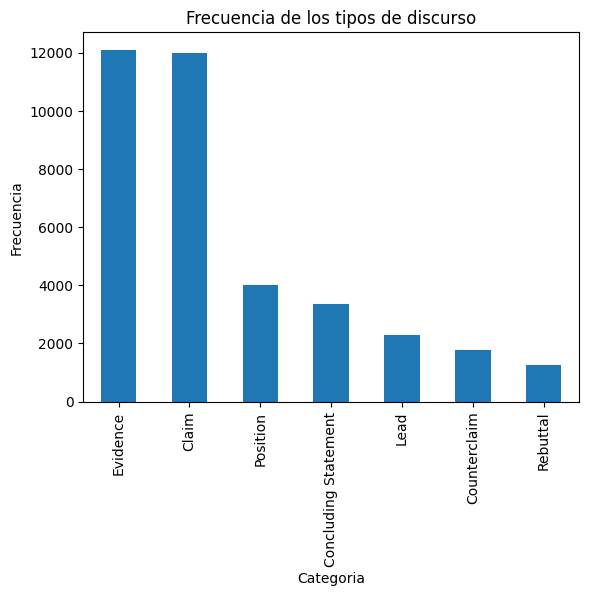

In [36]:
df["discourse_type"].value_counts().plot(kind='bar')
plt.title("Frecuencia de los tipos de discurso")
plt.xlabel("Categoria")
plt.ylabel("Frecuencia")
plt.show()

### Frecuencia de los distintos tipos de efectividad en discursos

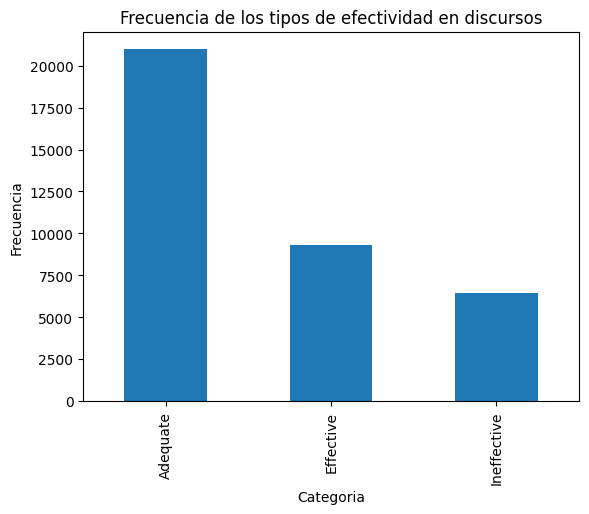

In [37]:
df["discourse_effectiveness"].value_counts().plot(kind='bar')
plt.title("Frecuencia de los tipos de efectividad en discursos")
plt.xlabel("Categoria")
plt.ylabel("Frecuencia")
plt.show()

### Caracteristicas de columna de texto

In [ ]:
# estadisticas simples